In [1]:
import math
from imldiff.comparers import DifferenceComparer
from imldiff.explainer import BaseSHAPExplainer
from imldiff.model import Model
from imldiff.plots import plot_decision_boundaries, force_plot, get_force_plot_ordering, make_pca_embedding_values
from imldiff.toy_examples.explainers import SHAPExplainer
from imldiff.util import printmd
import shap
from shap.maskers import Independent
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

## Create Models

In [2]:
feature_names = ['x1', 'x2']

In [3]:
step_factor = 1/2

class LinearClassifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([1.0 if x[0] + x[1] > 0.0 else 0.0 for x in X])

class SteppedClassifier(Model):
    def predict_proba(self, X):
        X = np.asarray(X)
        return np.array([1.0 if math.ceil(x[0]/step_factor - 1/4)*step_factor + math.ceil(x[1]/step_factor - 1/4)*step_factor > 0.0 else 0.0 for x in X])

In [4]:
number_of_samples = 1000
X = np.random.uniform(-1, 1, (number_of_samples, 2))
linear_classifier = LinearClassifier()
stepped_classifier = SteppedClassifier()
models = [linear_classifier, stepped_classifier]

In [5]:
predictions_a = linear_classifier.predict_proba(X)
predictions_b = stepped_classifier.predict_proba(X)
predictions = np.array([abs(b - a) for a, b in zip(predictions_a, predictions_b)])

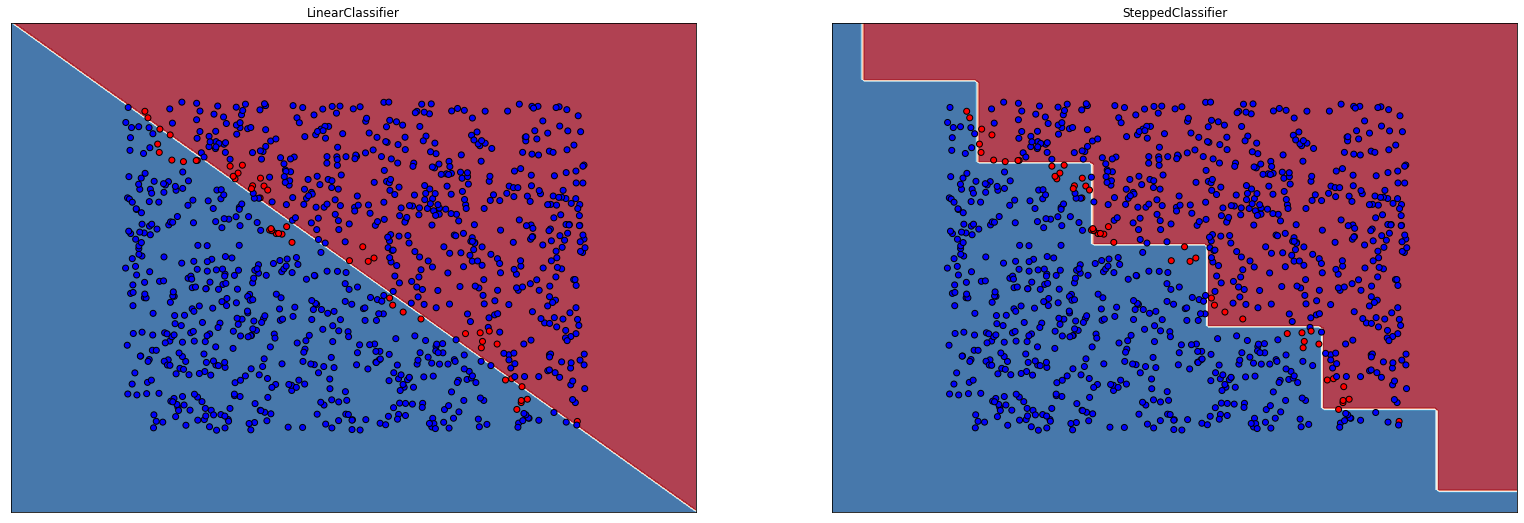

In [6]:
plot_decision_boundaries(models, X, predictions)

In [7]:
comparer = DifferenceComparer(linear_classifier, stepped_classifier)

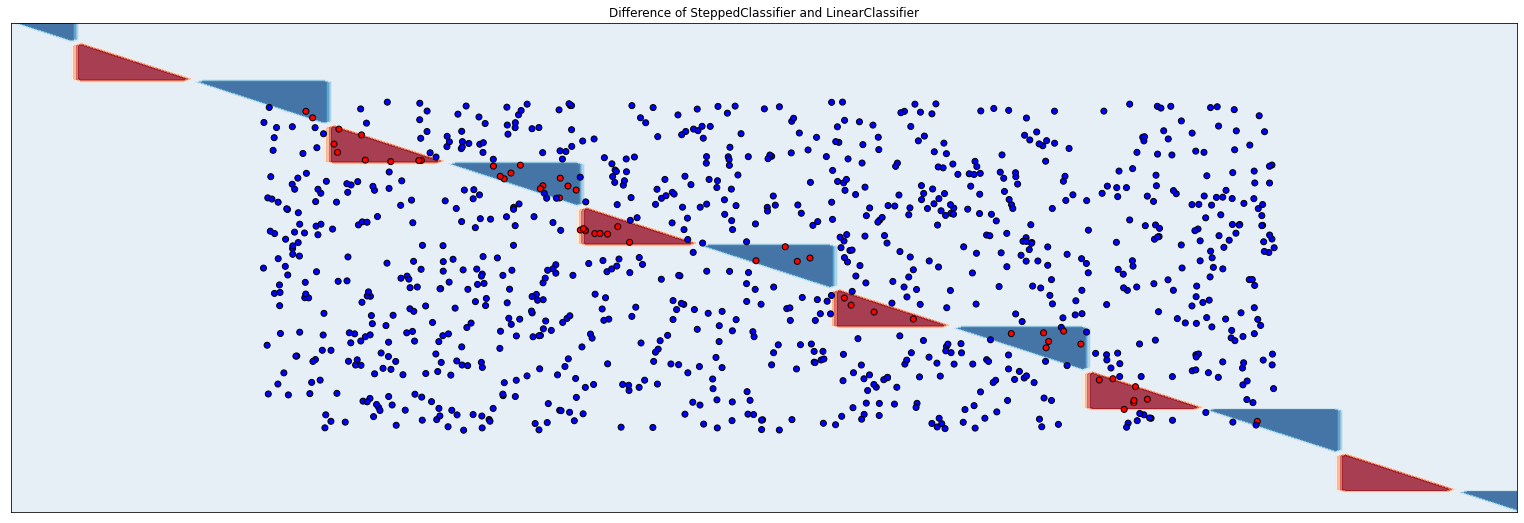

In [8]:
plot_decision_boundaries([comparer], X, predictions)

## Generate Explanations

In [9]:
notebook_name = 'Linear vs Stepped Decision Boundary'

explainer_a = SHAPExplainer(notebook_name + ' - Model A')
explainer_a.load_or_generate(comparer.model_a.predict_proba, X, feature_names=feature_names)
explainer_b = SHAPExplainer(notebook_name + ' - Model B')
explainer_b.load_or_generate(comparer.model_b.predict_proba, X, feature_names=feature_names)
single_model_explainers = [explainer_a, explainer_b]

shap_value_differences_explainer = SHAPExplainer(notebook_name + ' - SHAP Value Differences')
shap_value_differences_explainer.shap_values = explainer_b.shap_values - explainer_a.shap_values
shap_value_differences_explainer.shap_values.display_data = explainer_a.shap_values.display_data
shap_value_differences_explainer.shap_values.data = explainer_a.shap_values.data

difference_explainer = SHAPExplainer(notebook_name + ' - Difference Model')
difference_explainer.load_or_generate(comparer.predict_proba, X, feature_names=feature_names)

comparison_explainers = [shap_value_differences_explainer, difference_explainer]

explainers = [explainer_a, explainer_b, shap_value_differences_explainer, difference_explainer]

Finished generating: explanations/Linear vs Stepped Decision Boundary - Model A.exp (0:00:09.419567)
Finished generating: explanations/Linear vs Stepped Decision Boundary - Model B.exp (0:00:13.465560)
Finished generating: explanations/Linear vs Stepped Decision Boundary - Difference Model.exp (0:00:21.618145)


Exact explainer: 1001it [00:13, 16.98it/s]                         
Exact explainer: 1001it [00:21, 19.24it/s]                         


## Analyze

### Linear vs Stepped Decision Boundary - Model A

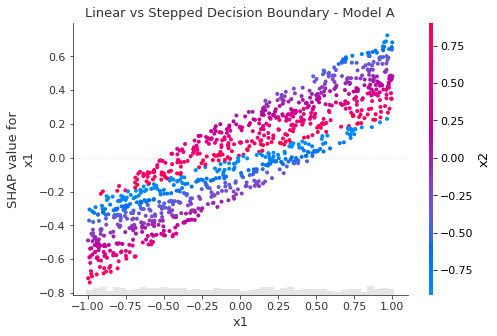

### Linear vs Stepped Decision Boundary - Model B

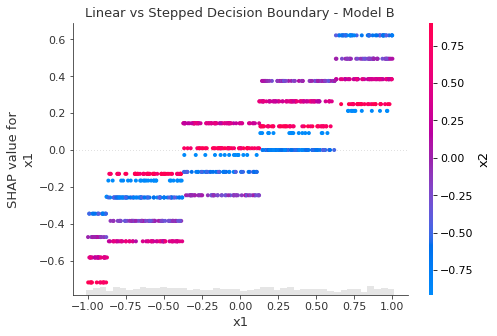

### Linear vs Stepped Decision Boundary - SHAP Value Differences

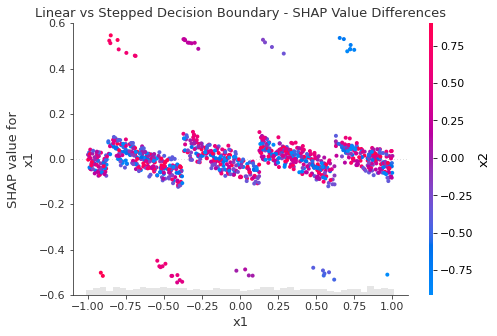

### Linear vs Stepped Decision Boundary - Difference Model

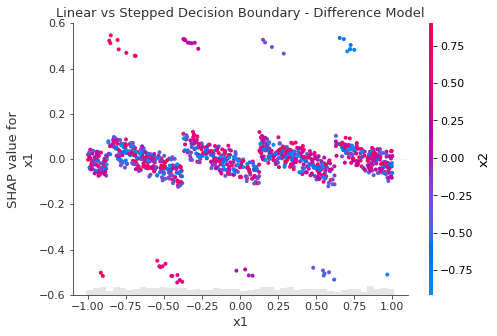

In [10]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.scatter(explainer.shap_values[:, feature_names[0]], color=explainer.shap_values, title=str(explainer))

### Linear vs Stepped Decision Boundary - Model A

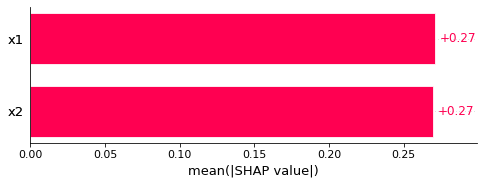

### Linear vs Stepped Decision Boundary - Model B

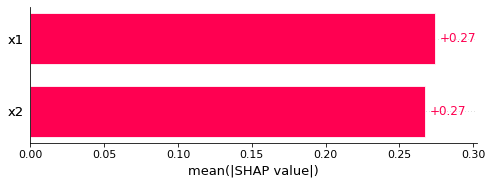

### Linear vs Stepped Decision Boundary - SHAP Value Differences

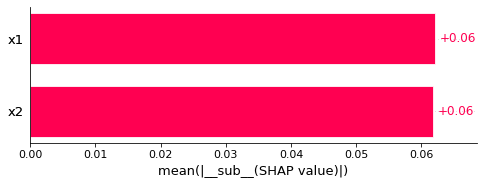

### Linear vs Stepped Decision Boundary - Difference Model

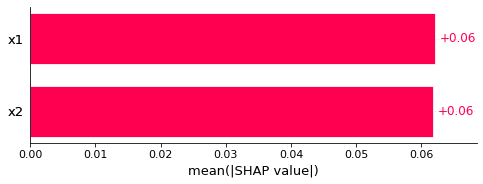

In [11]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.bar(explainer.shap_values)

### Linear vs Stepped Decision Boundary - Model A

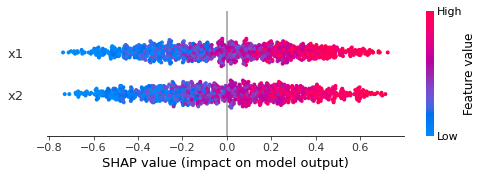

### Linear vs Stepped Decision Boundary - Model B

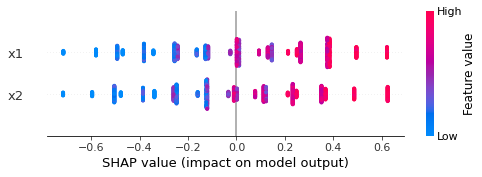

### Linear vs Stepped Decision Boundary - SHAP Value Differences

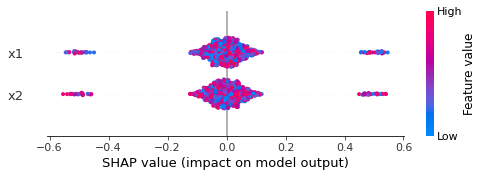

### Linear vs Stepped Decision Boundary - Difference Model

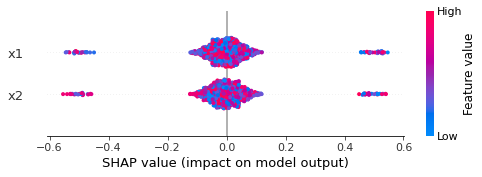

In [12]:
for explainer in explainers:
    printmd(f'### {explainer}')
    shap.plots.beeswarm(explainer.shap_values)

In [13]:
plot_a = force_plot(explainer_a)
ordering = get_force_plot_ordering(plot_a)
printmd(f'### {explainer_a}')
plot_a

### Linear vs Stepped Decision Boundary - Model A

In [14]:
printmd(f'### {explainer_b}')
force_plot(explainer_b, ordering)

### Linear vs Stepped Decision Boundary - Model B

In [15]:
printmd(f'### {shap_value_differences_explainer}')
force_plot(shap_value_differences_explainer)

### Linear vs Stepped Decision Boundary - SHAP Value Differences

In [16]:
printmd(f'### {difference_explainer}')
force_plot(difference_explainer)

### Linear vs Stepped Decision Boundary - Difference Model

### Linear vs Stepped Decision Boundary - Model A

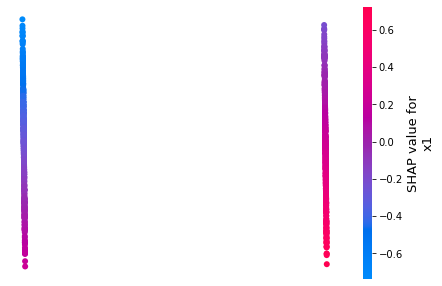

### Linear vs Stepped Decision Boundary - Model B

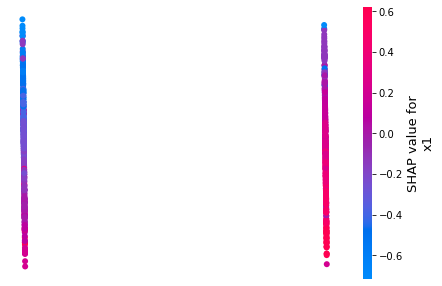

### Linear vs Stepped Decision Boundary - SHAP Value Differences

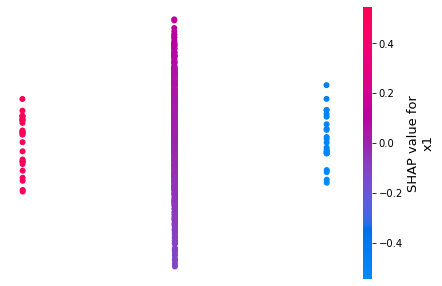

### Linear vs Stepped Decision Boundary - Difference Model

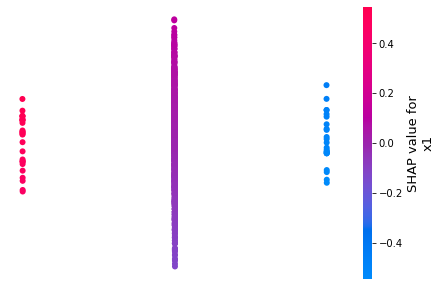

In [17]:
embedding_values = make_pca_embedding_values(explainer_a)
for explainer in single_model_explainers:
    printmd(f'### {explainer}')
    shap.plots.embedding(feature_names[0], explainer.shap_values.values, feature_names=feature_names, method=embedding_values)

for explainer in comparison_explainers:
    printmd(f'### {explainer}')
    shap.plots.embedding(feature_names[0], explainer.shap_values.values, feature_names=feature_names)

### Linear vs Stepped Decision Boundary - Model A

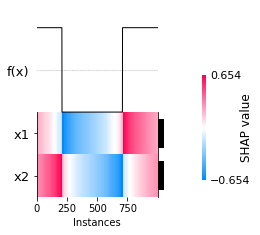

### Linear vs Stepped Decision Boundary - Model B

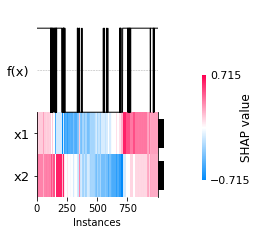

### Linear vs Stepped Decision Boundary - SHAP Value Differences

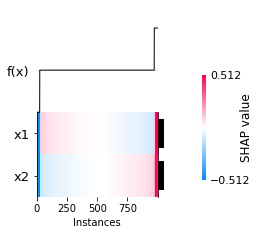

### Linear vs Stepped Decision Boundary - Difference Model

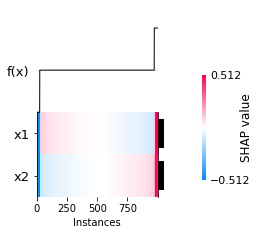

In [18]:
instance_order = explainer_a.shap_values.hclust()
feature_order = np.argsort(-explainer_a.shap_values.abs.mean(0).values)
for explainer in single_model_explainers:
    printmd(f'### {explainer}')
    shap.plots.heatmap(explainer.shap_values, instance_order=instance_order, feature_order=feature_order, max_display=len(feature_names))

for explainer in comparison_explainers:
    printmd(f'### {explainer}')
    shap.plots.heatmap(explainer.shap_values, max_display=len(feature_names))